# 人工神经网络应用
人工神经网络（Artificial Neural Netork,即ANN）是由简单神经元经过相互连接形成网状结构，通过调节各连接的权重值改变连接的强度，进而实现感知判断
反向传播(Back Propagation, BP) 算法的提出进一步推动了神经网络的发展。目前，神经网络作为一种重要的数据挖掘方法，已在医学诊断、信用卡欺诈识别、手写数字识别以及发动机的故障诊断等领域得到了广泛的应用。

## 导入库

In [1]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split
# tensorflow == 2.10.0 支持GPU
import tensorflow as tf

In [2]:
# 全文忽略警告信息
import warnings

warnings.filterwarnings("ignore")

## 处理数据
原始音频数据 约4GB，采用以下代码选取子数据集（train_data_sub.csv）作训练、测试

In [3]:
import shutil

src_dir = r'./dataset_city_voice'
sub_dir = os.path.join(src_dir, 'train_data')
train_data_ds = os.path.join(src_dir, 'train_data.csv')
tar_dir = os.path.join(src_dir, 'train_data_sub')

df = pd.read_csv(train_data_ds, header=0)
df.drop_duplicates(inplace=True)

train_data = pd.DataFrame(columns=df.columns)

# 按类别取100 * 10条 wav音频文件
num = 0
for clf in df['Class'].unique():
    for i in df.loc[df['Class'] == clf][:100].index:
        num += 1
        wav_src = os.path.join(sub_dir, f"{df.loc[i, 'ID']}.wav")
        wav_tar = os.path.join(tar_dir, f"{num}-{df.loc[i, 'Class']}.wav")
        shutil.copyfile(wav_src, wav_tar)  # 移动并重命名
        train_data.loc[num] = [num, df.loc[i, 'Class']]  # 子集对应的样本数据
train_data.to_csv(os.path.join(src_dir, 'train_data_sub.csv'), index=False)

In [4]:
src_dir = r'./dataset_city_voice'
sub_dir = os.path.join(src_dir, 'train_data_sub')
train_data_ds = os.path.join(src_dir, 'train_data_sub.csv')

images_dir = os.path.join(src_dir, 'images')
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

history_dir = os.path.join(src_dir, 'history')
if not os.path.exists(history_dir):
    os.mkdir(history_dir)

## 探索数据
案例中使用librosa作为音频处理库，首先加载train_data_sub.csv
然后计算每个对应音频的时长。

In [5]:
df = pd.read_csv(train_data_ds, header=0)
sound_cls = df['Class'].unique()
df = shuffle(df, random_state=42)


def get_detail(src_dir, data):
    for i in data.index:
        wav_file = os.path.join(src_dir, 'train_data_sub', f"{data.loc[i, 'ID']}-{data.loc[i, 'Class']}.wav")
        time_series, sampling_rate = librosa.load(wav_file)
        data.loc[i, 'duration'] = librosa.get_duration(y=time_series, sr=sampling_rate)
    # 若值相同，则无缺失值
    print('各字段数据个数: \n', data.count())
    # 统计各字段词频
    print('各类别计数分布: \n', data['Class'].value_counts())
    # 统计各音频的时长分布
    print('各音频时长分布: \n', data.describe()['duration'])
    return data

In [6]:
df = get_detail(src_dir, df)

各字段数据个数: 
 ID          1000
Class       1000
duration    1000
dtype: int64
各类别计数分布: 
 Class
gun_shot            100
air_conditioner     100
engine_idling       100
children_playing    100
jackhammer          100
street_music        100
siren               100
car_horn            100
drilling            100
dog_bark            100
Name: count, dtype: int64
各音频时长分布: 
 count    1000.000000
mean        3.434492
std         1.122418
min         0.050023
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64


- 数据集中有4560条音频数据的时长为4秒，其余的音频数据的时长均小于4秒，因此需要做部分预处理。

## 观察数据

In [7]:
def get_wavs(src_dir, data):
    wav_dict = {}
    # 10个类别
    sound_cls = data['Class'].unique()
    for s in sound_cls:
        # 每一类别的第1个音频
        tmp = data.loc[data['Class'] == s].values[0]
        wav_dict[tmp[1]] = os.path.join(src_dir, 'train_data_sub', f'{tmp[0]}-{tmp[1]}.wav')
    return wav_dict

In [8]:
wav_dict = get_wavs(src_dir, data=df)

## 波形图
下面将音频表示为波形（即波形幅度包络图），以直观地查看数据。
对于每一种类型的声音选择一条数据，然后使用librosa.display展示声音的波形图

In [9]:
def waveshow(src_dir, wav_dict):
    """
    绘制10个类别单个音频波形图
    :param src_dir: 
    :param wav_dict: 
    :return: 
    """
    for cls_name, wav_file in wav_dict.items():
        if os.path.exists(wav_file):
            time_series, sampling_rate = librosa.load(wav_file)
            plt.figure(figsize=(16, 4))
            plt.title(f'Amplitude Envelope for {cls_name}')
            # 波形图
            librosa.display.waveshow(time_series, sr=sampling_rate, color='red')
            plt.tight_layout()
            plt.savefig(os.path.join(src_dir, 'images', f'Amplitude Envelope for {cls_name}.png'))
            plt.show()
            plt.close()
        else:
            print(f'FileNotFound: {wav_file}')

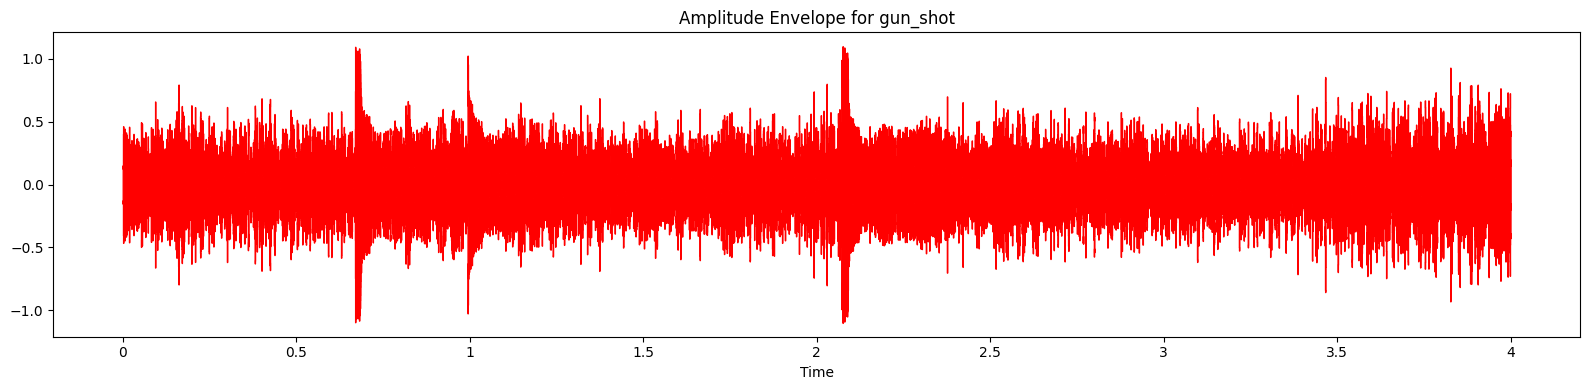

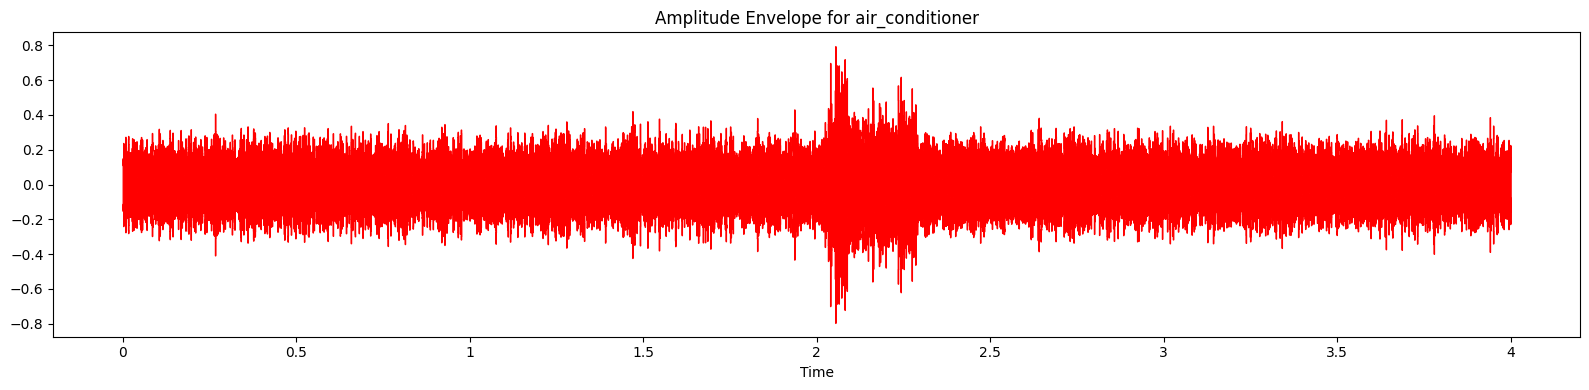

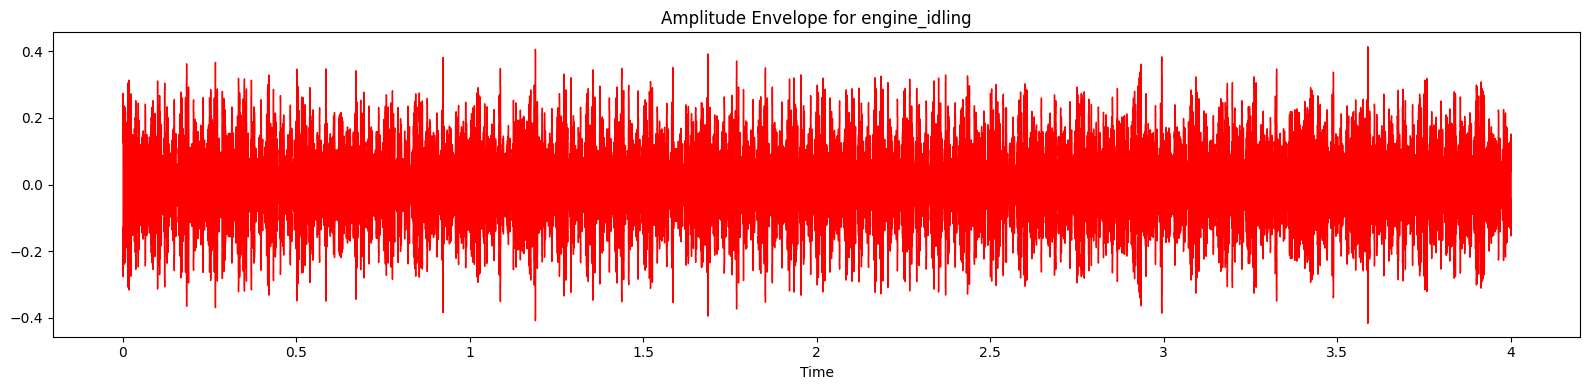

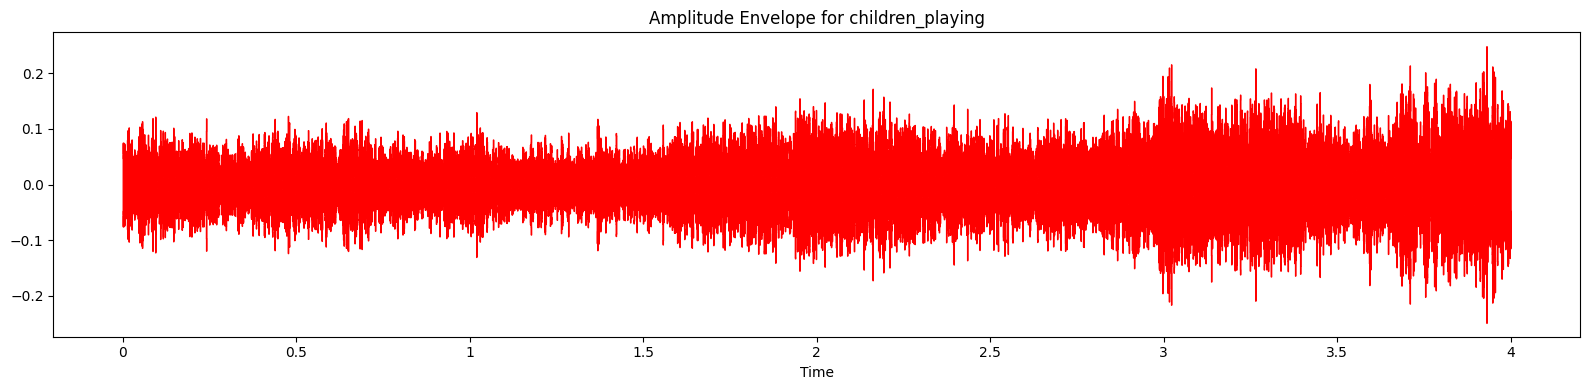

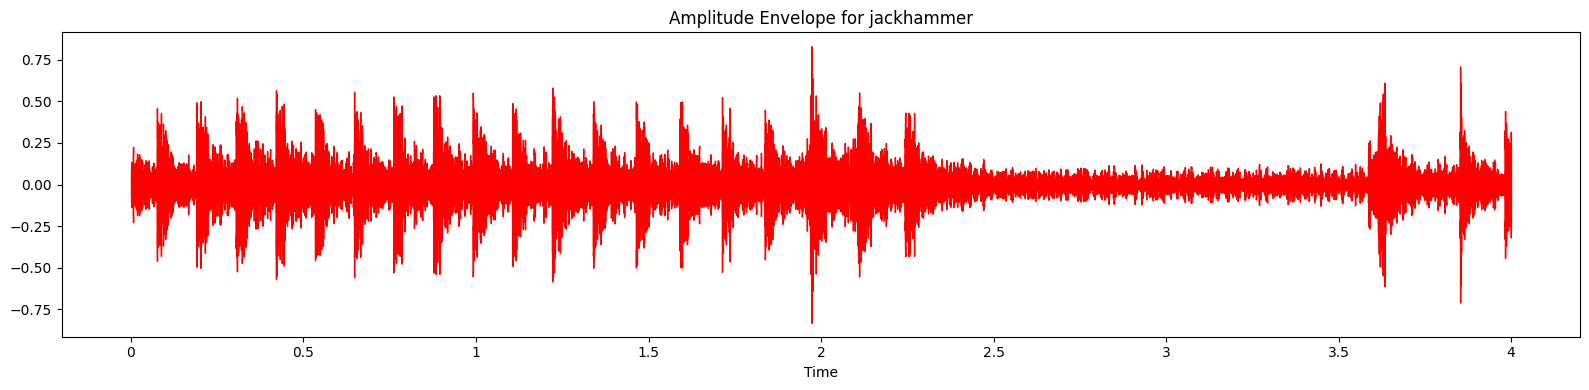

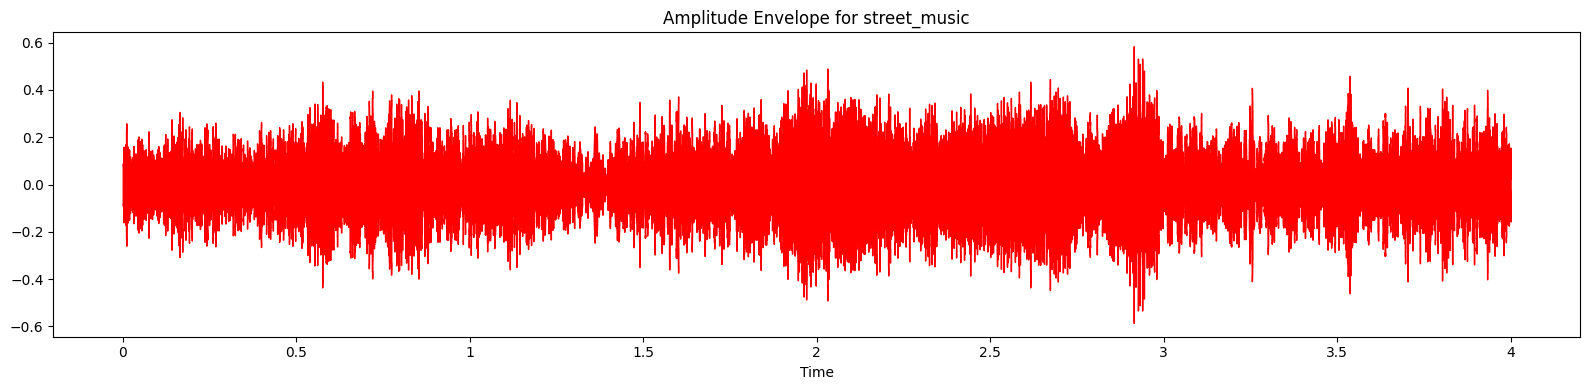

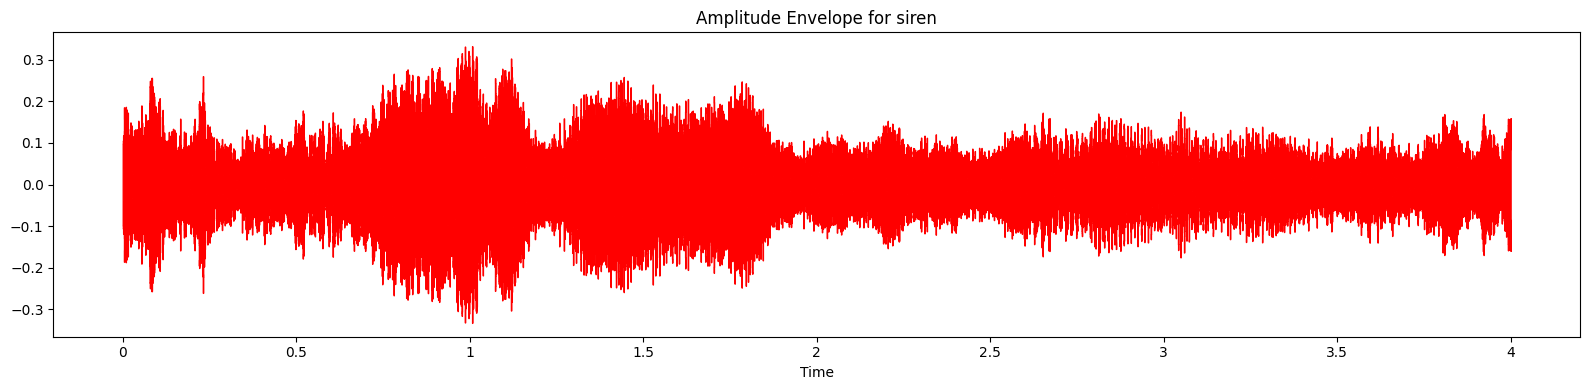

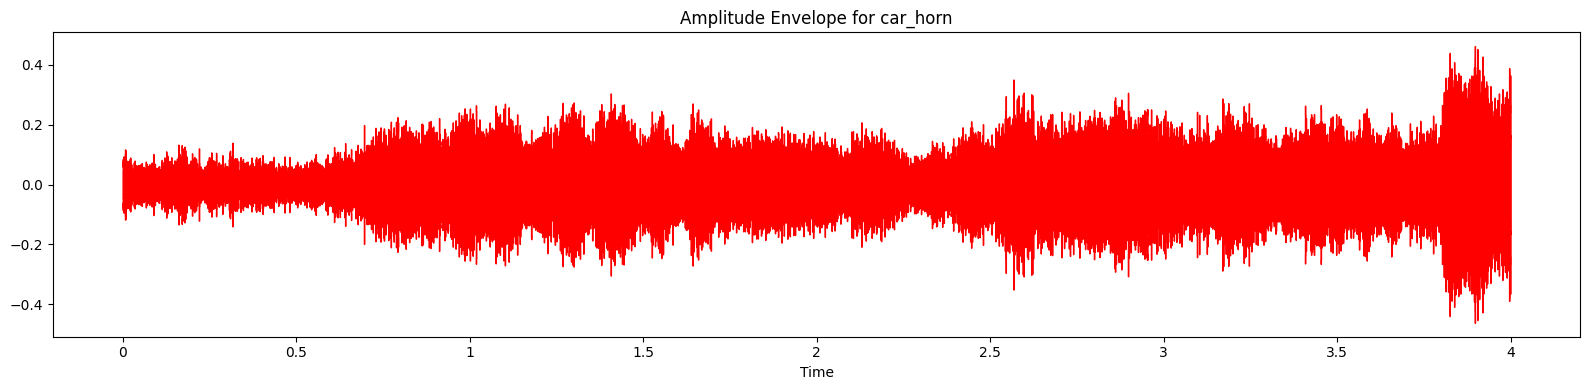

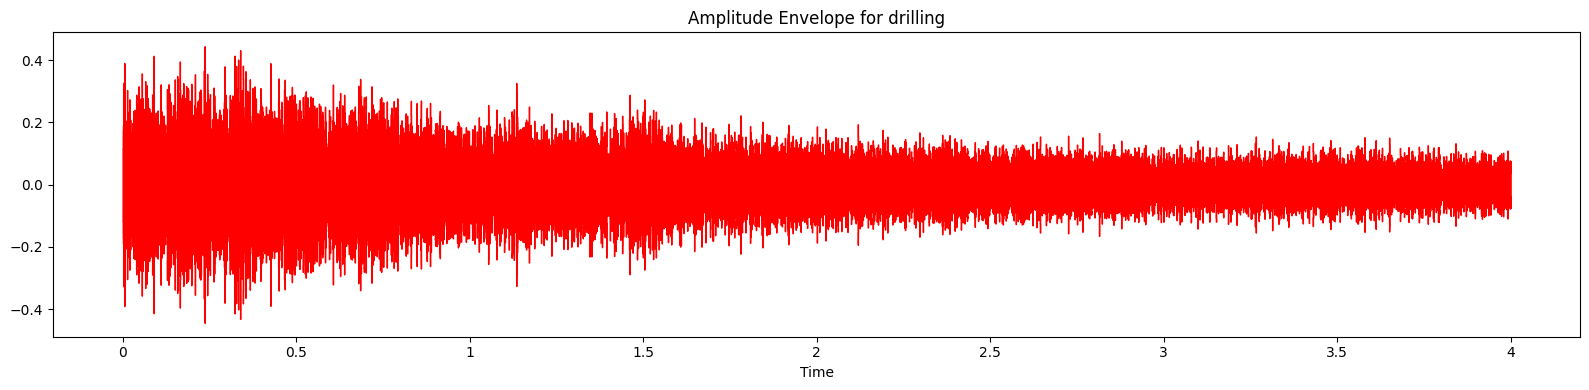

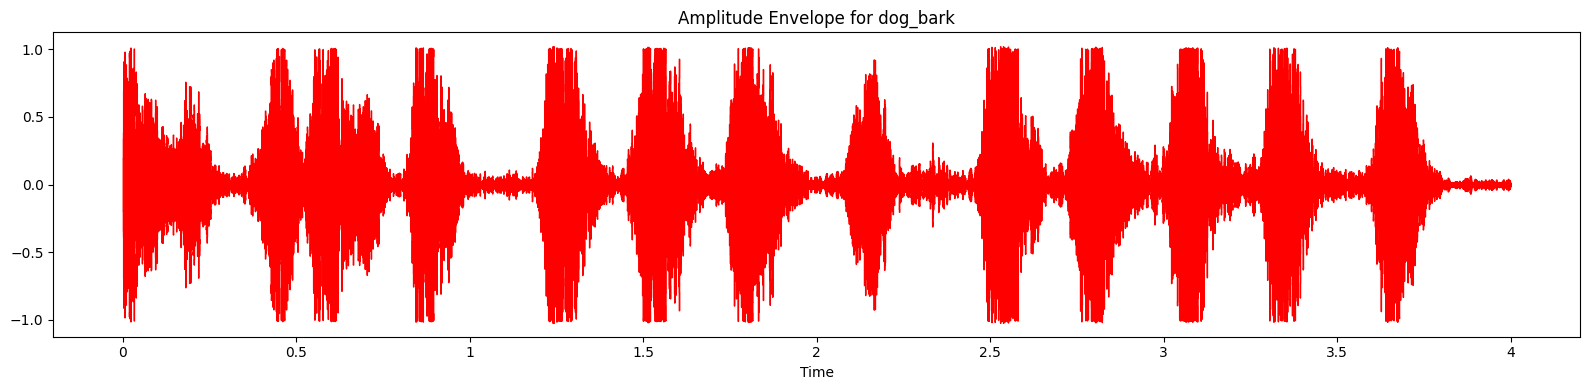

In [10]:
waveshow(src_dir, wav_dict)

In [11]:
def specshow(src_dir, wav_dict):
    """
    绘制10个类别单个音频的频谱图（线性）
    :param src_dir: 
    :param wav_dict: 
    :return: 
    """
    for cls_name, wav_file in wav_dict.items():
        time_series, sampling_rate = librosa.load(wav_file)
        # 短时傅里叶变换 (STFT)
        X = librosa.stft(time_series)
        # 将振幅频谱图转换为dB标度频谱图
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.figure(figsize=(16, 4))
        plt.title(f'Amplitude Envelope for {cls_name}-Hz')
        # 显示频谱图/色谱图/cgt/etc
        librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(os.path.join(src_dir, 'images', f'Amplitude Envelope for {cls_name}-Hz.png'))
        plt.show()

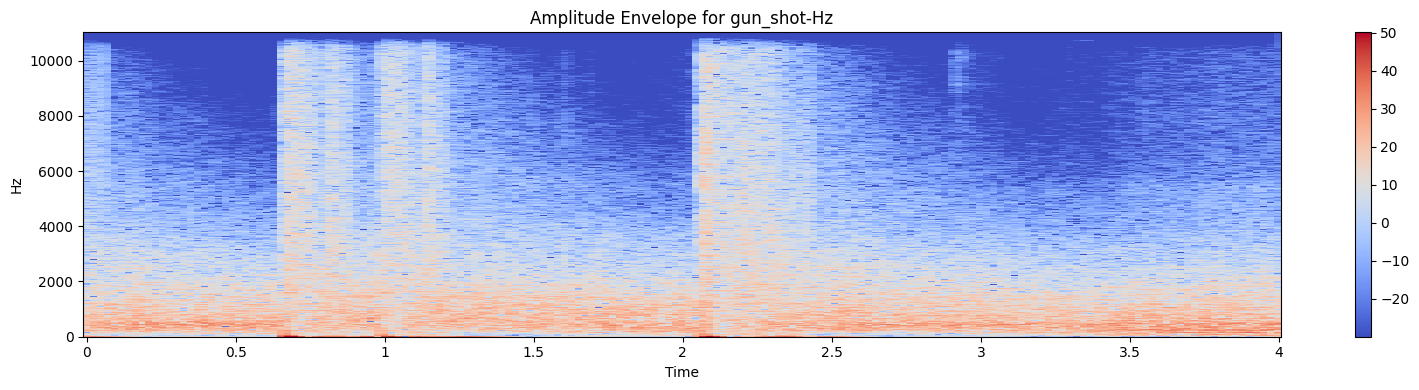

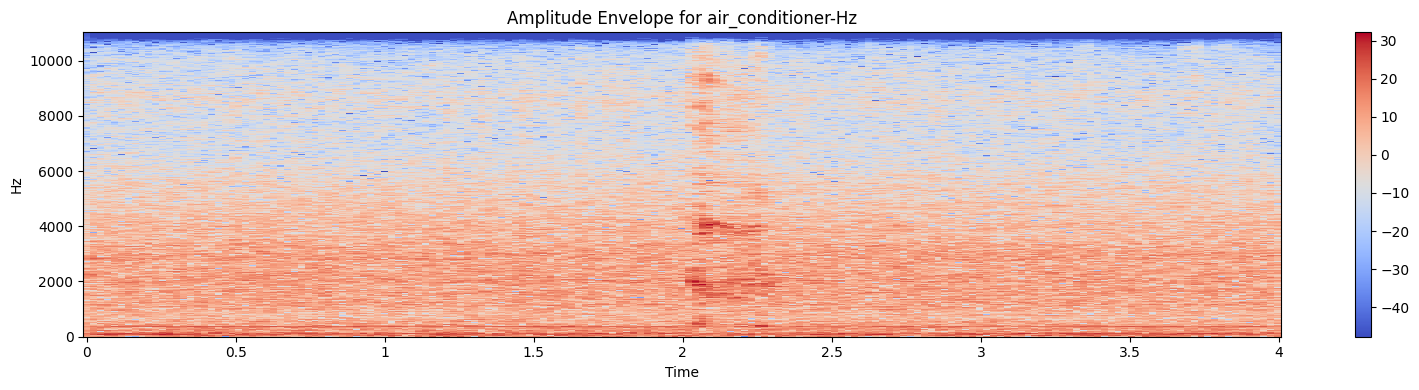

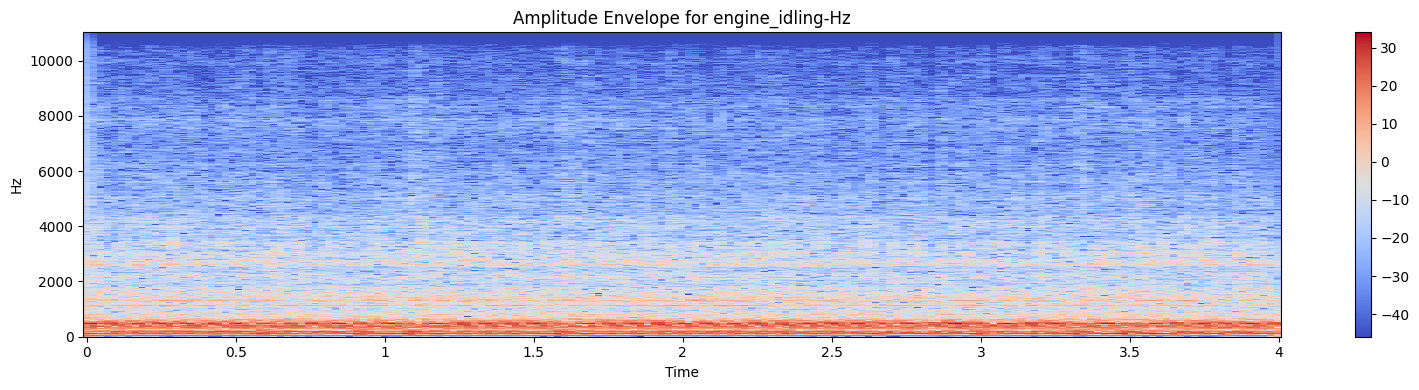

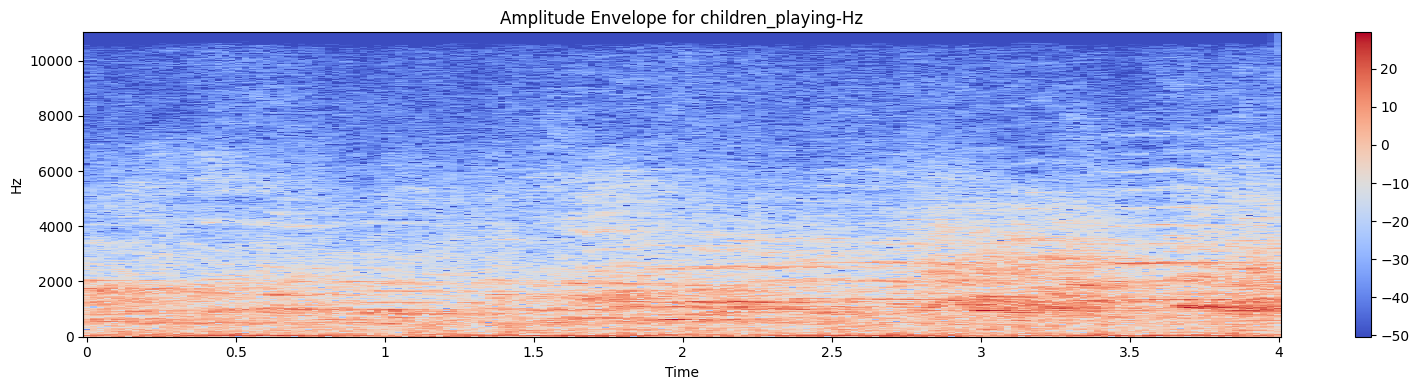

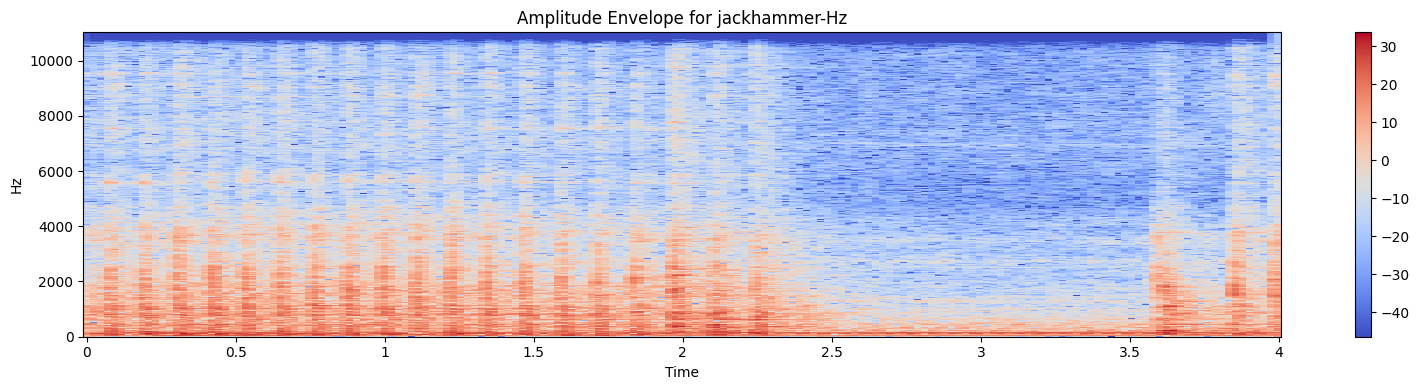

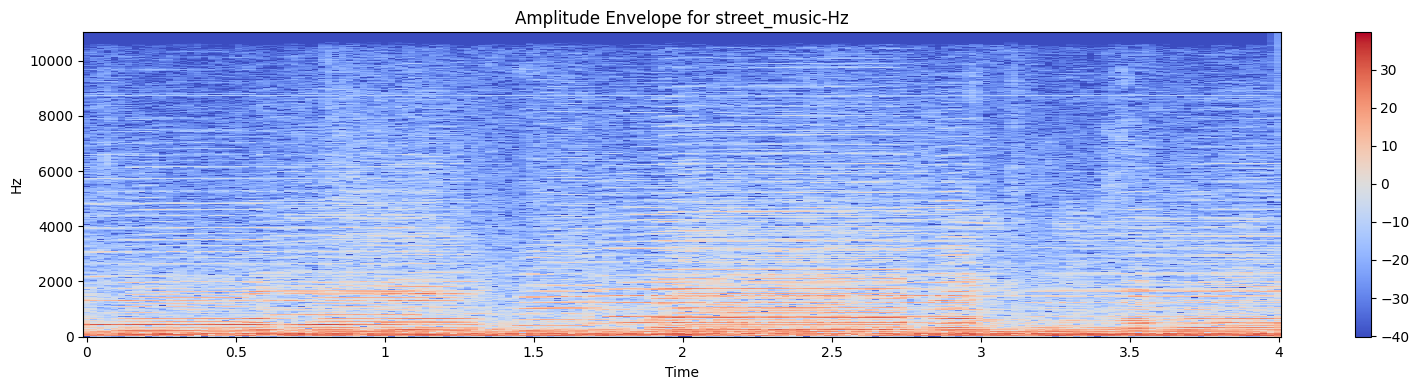

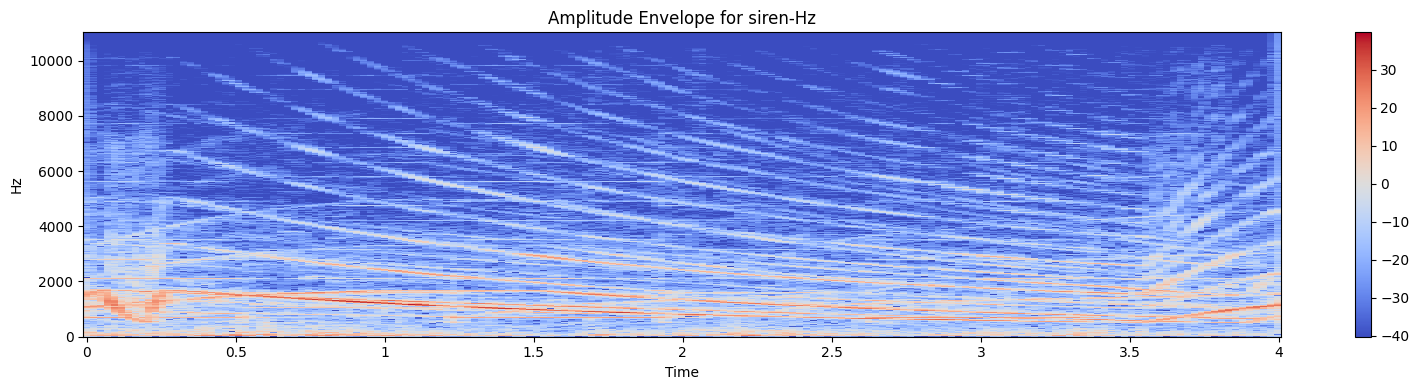

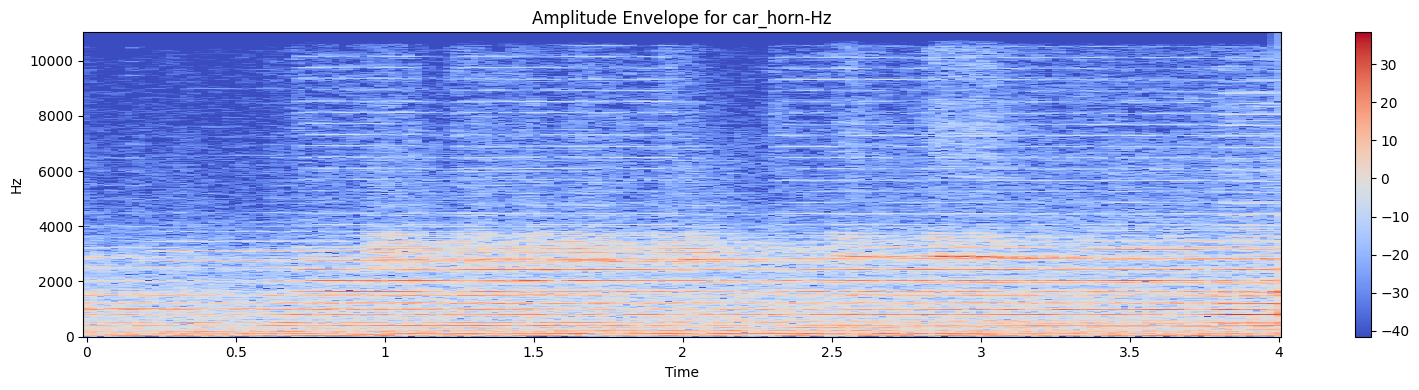

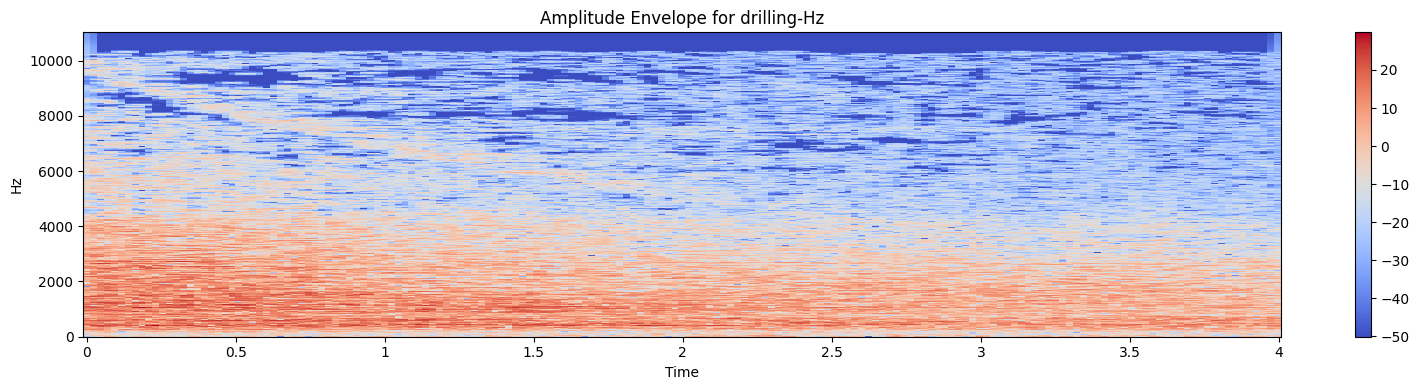

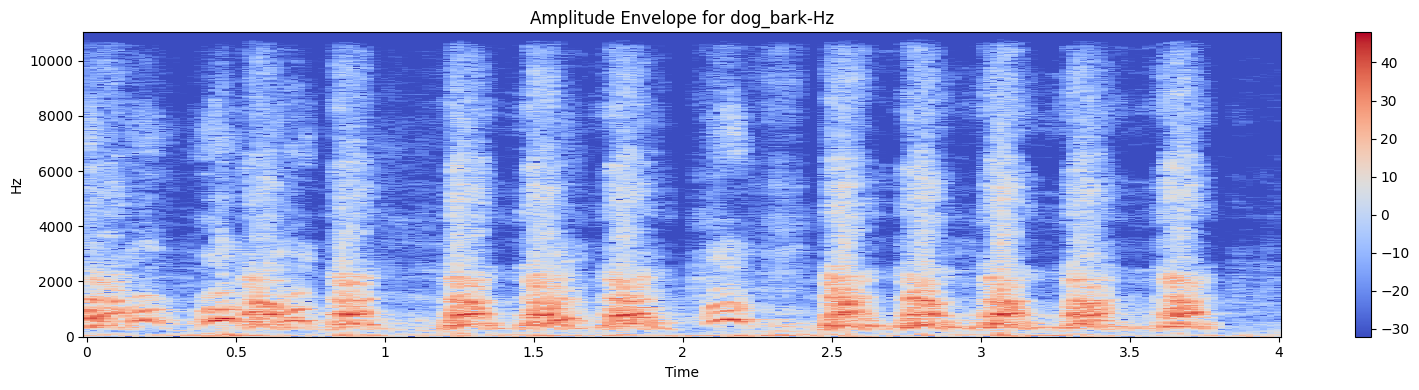

In [12]:
specshow(src_dir, wav_dict)

In [13]:
def specshow_log(src_dir, wav_dict):
    """
    绘制10个类别单个音频的频谱图（对数）
    :param src_dir: 
    :param wav_dict: 
    :return: 
    """
    for cls_name, wav_file in wav_dict.items():
        time_series, sampling_rate = librosa.load(wav_file)
        X = librosa.stft(time_series)
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.figure(figsize=(16, 4))
        plt.title(f'Amplitude Envelope for {cls_name}-log(Hz)')
        # y_axis='log' 表示频谱以对数刻度显示
        librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(os.path.join(src_dir, 'images', f'Amplitude Envelope for {cls_name}-log_Hz.png'))
        plt.show()

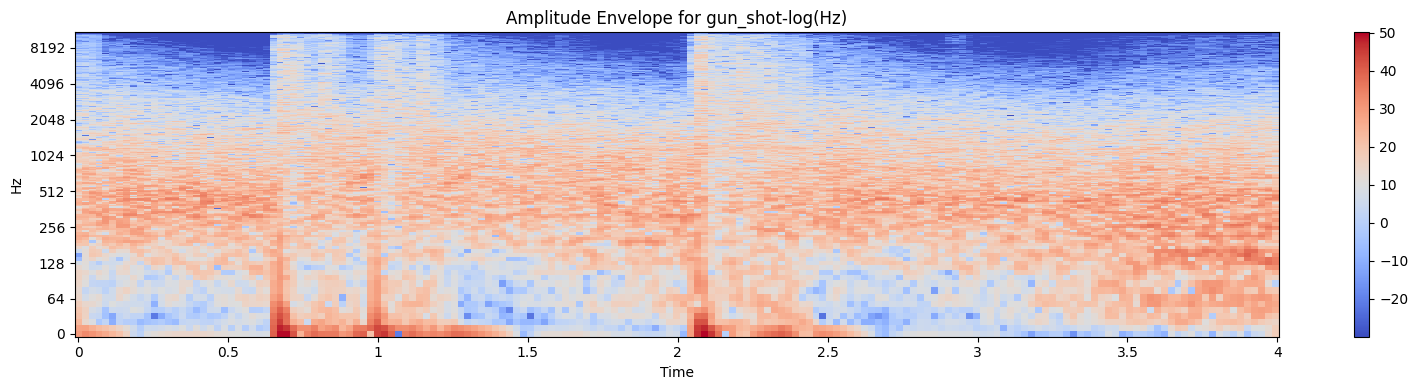

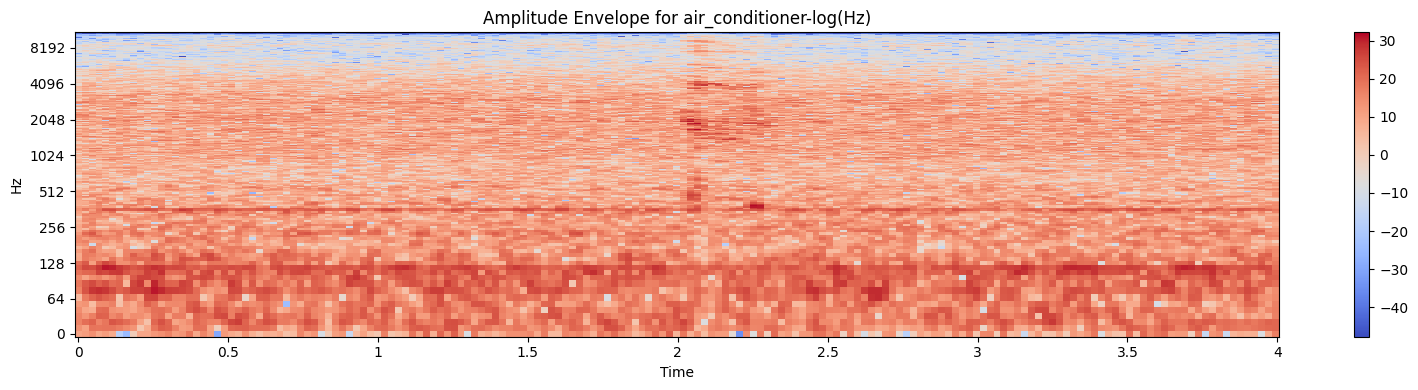

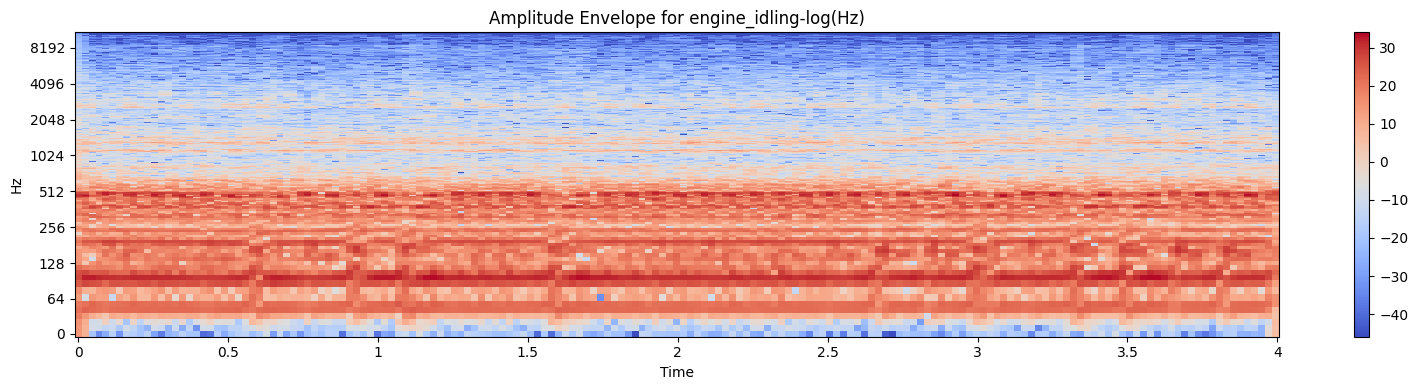

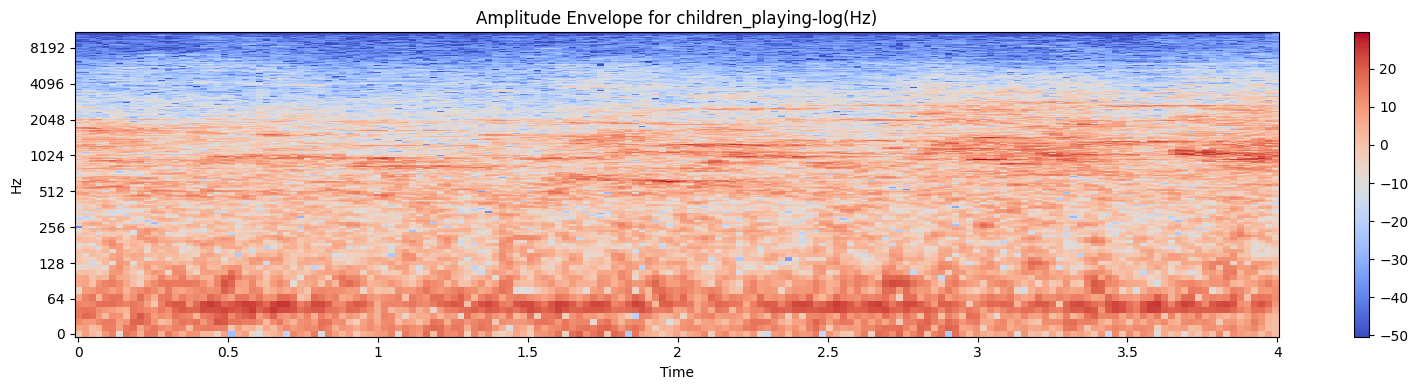

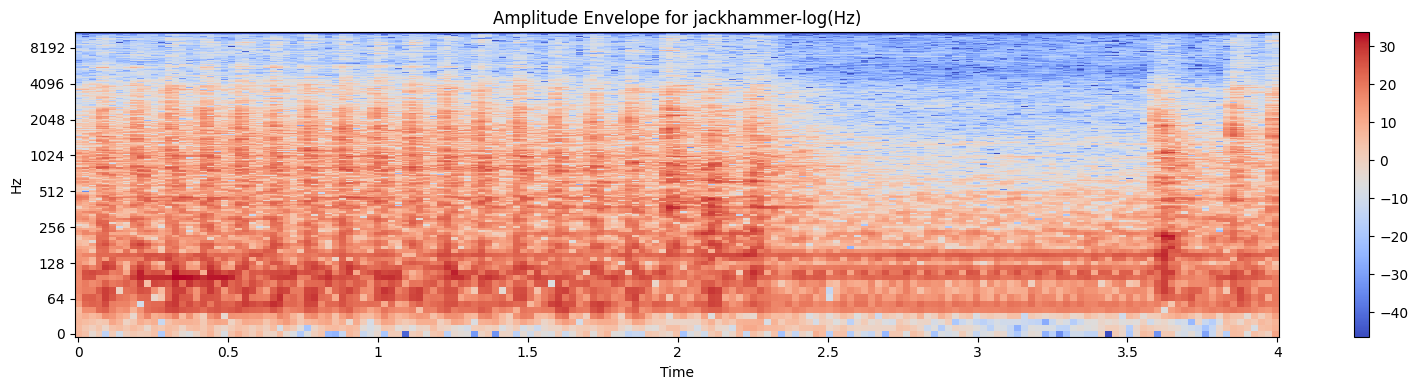

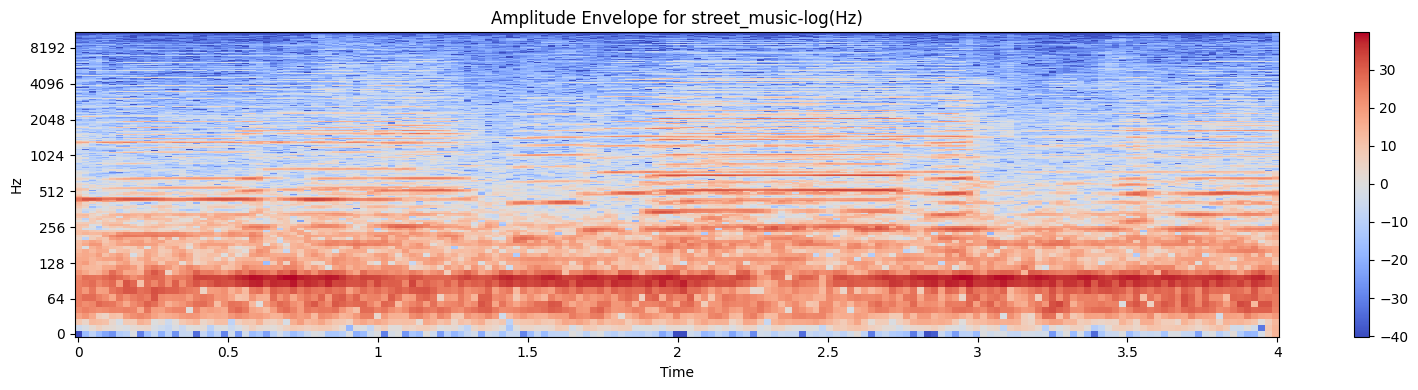

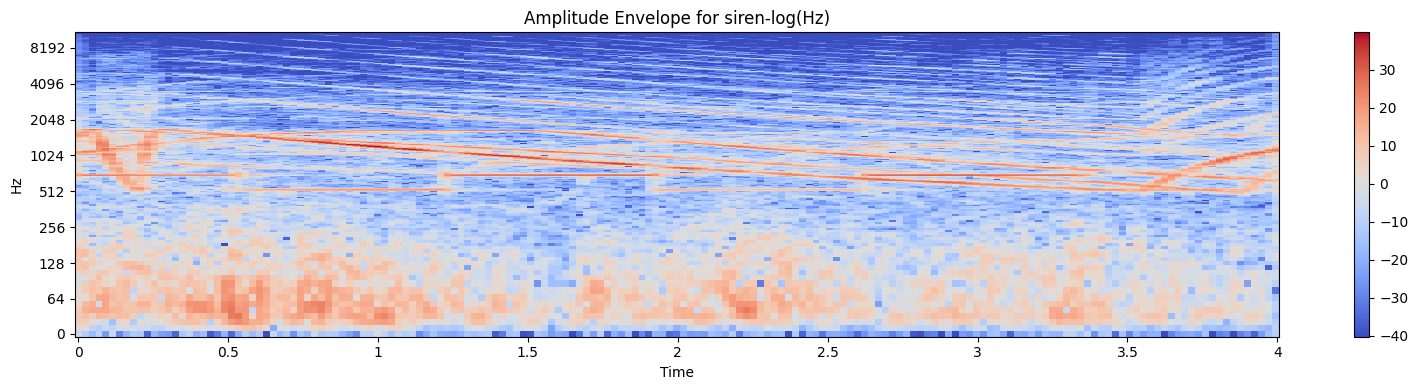

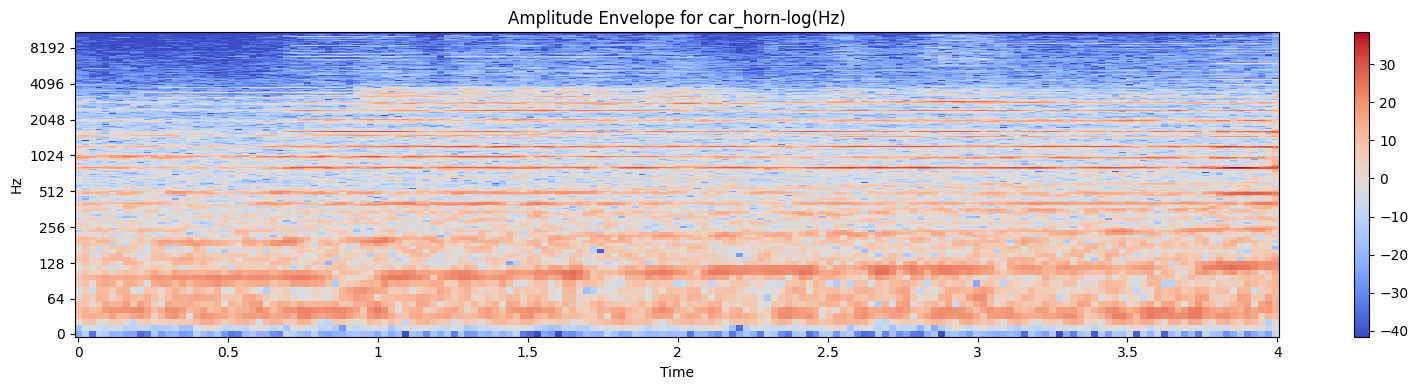

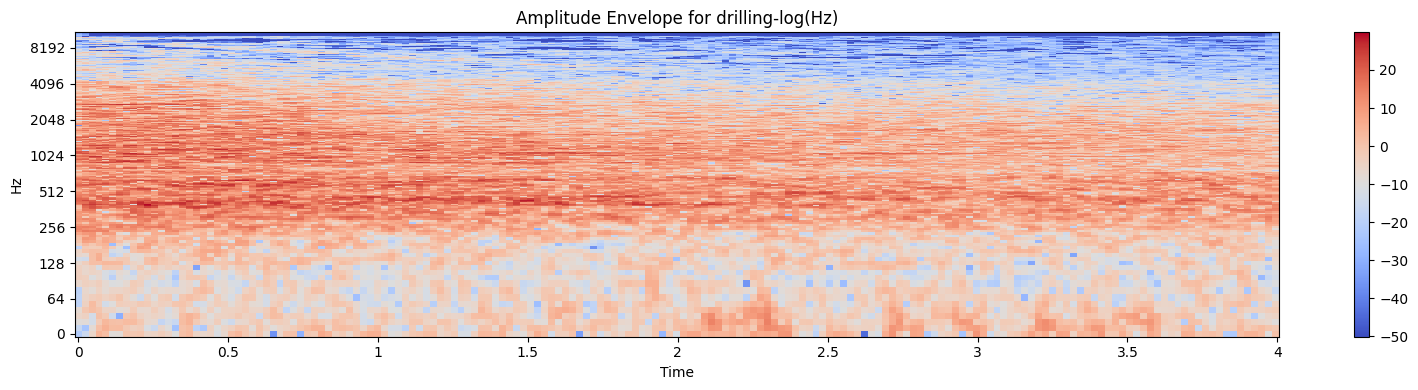

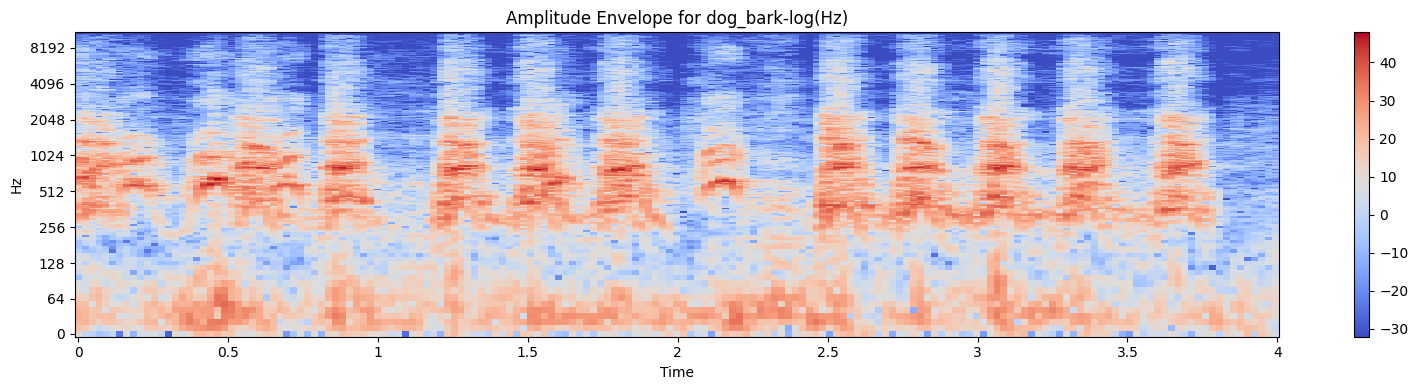

In [14]:
specshow_log(src_dir, wav_dict)

## 特征提取
由于标签值为字符串形式，在深度学习模型中不便于表示，因此这里使用sklearn的LabelEncoder()将字符串转换为数值形式

In [15]:
le = LabelEncoder()
le.fit(sound_cls)
# 把字符串类别转换为数值型类别
df['label'] = le.transform(df['Class'])
# 保存处理过程数据集
df.to_csv(os.path.join(src_dir, 'train_data_sub_detail.csv'), index=False)

In [16]:
# 当前字段内容
df.columns

Index(['ID', 'Class', 'duration', 'label'], dtype='object')

这里数据预处理将着重在特征工程的处理上。音频是非结构化的信息，包含了很多特征，需要根据问题的需要提取相应的特征。下面先介绍常用的音频特征。
a)	过零率（zero crossing rate）
过零率广泛地应用于语音识别和音乐信息检索领域。在对音频信号的采集中，一般首先进行分帧，从而将一段连续的音频信息转为离散的时间序列。由于音频有频率的变化，在离散的音频分帧下，音频信号从正变为负，或从负变为正则视为一次过零。单位时间内过零的次数即为过零率。短时评价过零率可视为音频信号的频率的一种简单度量，可以粗略地估计频谱的特征。在librosa中，使用下面语句提取过零率。
b)	光谱质心（spectral centroid）
光谱质心是描述音频的音色特征的重要参数之一。光谱质心表示为频率的重心，即在一定频率范围内通过能量加权平均的频率。光谱质心体现了声音的频率分布和能量分布。从主观上看，光谱质心代表了声音的明亮度。若声音较为低沉，则音频含有较多低频的信号，那么光谱质心就相应较低；若声音较为明亮，则频率信号较高，相应的光谱质心就相应较高。在librosa中，使用下面语句提取光谱质心。
c)	色度（chroma）
音乐领域有著名的十二平均律的说法。十二平均律规定了两个单音的相对音高。简而言之，十二平均律将纯八度分为了十二份，每一份表示为一个半音，两份表示为一个全音。色度特征是对这十二种半音的一种描述。色度特征可以捕获音乐的谐波和旋律特征，同时对音色和乐器的变化有稳健性。在librosa中，使用下面语句提取色度特征。
d)	调性网络（tonnetz）
调性网络表示音高特性的另一种特征，其在十二平均律的基础上加入了和弦结构信息（五度循环圈），得到了六维的特征信息。从另一个角度上看，调性网络计算了音频的音调质心特征。在librosa中，使用下面语句提取调性网络特征。
e)	梅尔频率倒谱系数（Mel Frequency Cepstrum Coefficient，MFCC）
MFCC是在音频识别领域非常重要的概念，在相当长的一段时间内代表了语音识别中最有效的音频特征。声道的形状会在语音短时功率谱的包络中显示出来，而MFCC可以准确地描述这种包络。对MFCC的提取过程一般有以下几个过程：首先对音频信号进行预加重、分帧和加窗，这一步旨在加强语音信号性能；然后通过快速傅里叶变换得到相应的频谱；再将上面的频谱通过Mel滤波器得到Mel频谱，通过Mel频谱可以将线性的自然频谱转换为体现人类听觉特性的Mel频谱；最后在Mel频谱上进行倒谱分析，获得的MFCC作为语音特征。在librosa中，使用下面语句提取MFCC特征。
本案例中着重讲解提取梅尔频率倒谱系数MFCC特征和色度特征chroma，同时也提取了其他特征

## 梅尔频率倒谱系数
对于每一个wav文件，需要根据其ID读取相应的音频文件，然后使用librosa库提取MFCC特征。由于源文件中各音频长度不等，因此提取出的MFCC特征会有不等的时间步维度。本案例将采取两种方式来处理该问题：第一种是直接对各个时间步的特征值求平均；第二种是将长度较短的特征向量补全到统一的长度。对于补全后的特征矩阵，使用sklearn.preprocessing.scale()将数据标准化，使得数据无量纲化，避免数据太大引发的数据问题

In [17]:
def parse_wav_1(sub_dir, data):
    """
    提取音频文件的特征矩阵
    梅尔频率倒谱系数
    :param sub_dir: 
    :param data: 
    :return: 
    """
    n_mfcc = 40
    all_mfcc = np.empty((0, n_mfcc, 173))
    all_mfcc_m = np.empty((0, n_mfcc))
    all_mfcc_scale = np.empty((0, n_mfcc, 173))
    for row in data:
        wav_file = os.path.join(sub_dir, f'{row[0]}-{row[1]}.wav')
        time_series, sampling_rate = librosa.load(wav_file)
        mfcc = librosa.feature.mfcc(y=time_series, sr=sampling_rate, n_mfcc=n_mfcc)
        mfcc_m = np.mean(mfcc, axis=1)
        if mfcc.shape[1] < 173:
            padding = np.zeros((n_mfcc, 173 - mfcc.shape[1]))
            mfcc = np.concatenate([mfcc, padding], axis=1)
        all_mfcc = np.vstack((all_mfcc, [mfcc]))
        all_mfcc_m = np.vstack((all_mfcc_m, [mfcc_m]))
        mfcc_scale = scale(mfcc)
        all_mfcc_scale = np.vstack((all_mfcc_scale, [mfcc_scale]))
    return all_mfcc, all_mfcc_m, all_mfcc_scale

In [18]:
all_mfcc, all_mfcc_m, all_mfcc_scale = parse_wav_1(sub_dir, data=df.values)
y = np.array(df['label'].tolist())
# (1000，40，173) (1000， 40) (100，40，173)
np.savez(os.path.join(src_dir, 'train_data_mfcc.npz'),
         all_mfcc=all_mfcc, all_mfcc_m=all_mfcc_m, y=y,
         all_mfcc_scale=all_mfcc_scale)
print(all_mfcc.shape, all_mfcc_m.shape, all_mfcc_scale.shape)

(1000, 40, 173) (1000, 40) (1000, 40, 173)


In [19]:
def parse_wav_2(sub_dir, data):
    """
    提取音频文件的特征矩阵
    色度
    :param sub_dir: 
    :param data: 
    :return: 
    """
    all_chroma = np.empty((0, 12, 173))
    all_chroma_m = np.empty((0, 12))
    all_chroma_scale = np.empty((0, 12, 173))
    for row in data:
        wav_file = os.path.join(sub_dir, f'{row[0]}-{row[1]}.wav')
        time_series, sampling_rate = librosa.load(wav_file)
        chroma = librosa.feature.chroma_stft(y=time_series, sr=sampling_rate)
        chroma_m = np.mean(chroma, axis=1)
        if chroma.shape[1] < 173:
            padding = np.zeros((12, 173 - chroma.shape[1]))
            chroma = np.concatenate([chroma, padding], axis=1)
        all_chroma = np.vstack((all_chroma, [chroma]))
        all_chroma_m = np.vstack((all_chroma_m, [chroma_m]))
        chroma_scale = scale(chroma)
        all_chroma_scale = np.vstack((all_chroma_scale, [chroma_scale]))
    return all_chroma, all_chroma_m, all_chroma_scale

In [20]:
all_chroma, all_chroma_m, all_chroma_scale = parse_wav_2(sub_dir=sub_dir, data=df.values)
y = np.array(df['label'].tolist())
# (1000，12，173) (100，12) (1000，12，173)
np.savez(os.path.join(src_dir, 'train_data_chroma.npz'),
         all_chroma=all_chroma, all_chroma_m=all_chroma_m, y=y,
         all_chroma_scale=all_chroma_scale)
print(all_chroma.shape, all_chroma_m.shape, all_chroma_scale.shape)

(1000, 12, 173) (1000, 12) (1000, 12, 173)


In [21]:
def parse_wav_3(sub_dir, data):
    """
    提取音频文件的特征矩阵
    过零率、谱质心、梅尔频率倒谱系数、色度、调性网络
    :param sub_dir: 
    :param data: 
    :return: 
    """
    # 过零率
    all_zrc_m = np.empty((0, 1))
    # 光谱质心
    all_cent_m = np.empty((0, 1))
    # 梅尔频率倒谱系数
    all_mfcc_m = np.empty((0, 20))
    # 色度
    all_chroma_m = np.empty((0, 12))
    # 调性网络
    all_tonnetz_m = np.empty((0, 6))
    for row in data:
        wav_file = os.path.join(sub_dir, f'{row[0]}-{row[1]}.wav')
        time_series, sampling_rate = librosa.load(wav_file)
        zcr = librosa.feature.zero_crossing_rate(time_series)
        cent = librosa.feature.spectral_centroid(y=time_series, sr=sampling_rate)
        # 梅尔频率倒谱系数(mfcc) 20维度
        mfccs = librosa.feature.mfcc(y=time_series, sr=sampling_rate, n_mfcc=20)
        # 色度(chroma stft)
        chroma = librosa.feature.chroma_stft(y=time_series, sr=sampling_rate)
        # 调性网络 (tonnetz)
        tonnetz = librosa.feature.tonnetz(y=time_series, sr=sampling_rate)
        # 按列计算均值
        zrc_m = np.mean(zcr, axis=1).T
        cent_m = np.mean(cent, axis=1).T
        mfccs_m = np.mean(mfccs, axis=1).T
        chroma_m = np.mean(chroma, axis=1).T
        tonnetz_m = np.mean(tonnetz, axis=1).T
        # 标准化 无量纲处理
        mfccs_m = scale(mfccs_m)
        chroma_m = scale(chroma_m)
        tonnetz_m = scale(tonnetz_m)
        # 按垂直顺序（按行）堆叠数组 10类音频
        all_zrc_m = np.vstack((all_zrc_m, [zrc_m]))
        all_cent_m = np.vstack((all_cent_m, [cent_m]))
        all_mfcc_m = np.vstack((all_mfcc_m, [mfccs_m]))
        all_chroma_m = np.vstack((all_chroma_m, [chroma_m]))
        all_tonnetz_m = np.vstack((all_tonnetz_m, [tonnetz_m]))
    return scale(all_zrc_m), scale(all_cent_m), all_mfcc_m, all_chroma_m, all_tonnetz_m

In [22]:
all_zrc_m, all_cent_m, all_mfcc_m, all_chroma_m, all_tonnetz_m = \
    parse_wav_3(sub_dir=sub_dir, data=df.values)
# 水平顺序堆叠数组 (按列)
features = np.hstack([all_zrc_m, all_cent_m, all_mfcc_m, all_chroma_m, all_tonnetz_m])
y = np.array(df['label'].tolist())
# 将多个数组以未压缩的 .npz 式保存到单个文件中
np.savez(os.path.join(src_dir, 'train_data_features.npz'),
         features=features, y=y)
print(all_zrc_m.shape, all_cent_m.shape, all_mfcc_m.shape,
      all_chroma_m.shape, all_tonnetz_m.shape)

(1000, 1) (1000, 1) (1000, 20) (1000, 12) (1000, 6)


## MLP多层感知机

In [23]:
def mlp(x_train, y_train, x_test, y_test,
        learning_rate=0.01, batch_size=200, epochs=100,
        loss='categorical_crossentropy', metrics=['accuracy']):
    """
    MLP多层感知机
    输入层 
    隐含层1：激活函数Relu
    隐含层2：激活函数Relu
    输出层：softmax
    :param x_train: 
    :param y_train: 
    :param x_test: 
    :param y_test: 
    :param learning_rate: 
    :param batch_size: 
    :param epochs: 
    :param loss: 
    :param metrics: 
    :return: 返回model.fit()结果
    """
    # 输入层 (样本数)
    inputs = tf.keras.Input(shape=(len(x_train[0]),))
    # print('MLP Inputs shape:',inputs.shape)
    # 隐含层1 (50个神经元)
    hidden_layer_1 = tf.keras.layers.Dense(units=50, activation='relu')(inputs)
    # 隐含层2 (50个神经元)
    hidden_layer_2 = tf.keras.layers.Dense(units=50, activation='relu')(hidden_layer_1)
    # 输出层 (10个类别)
    outputs = tf.keras.layers.Dense(units=10, activation='softmax')(hidden_layer_2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=loss, metrics=metrics)
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size, epochs=epochs, verbose=0)
    return history

## 评估模型

In [31]:
def show(history, tar_png):
    """
    绘制双轴折线图
    :param history: 
    :param tar_png: 
    :return: 
    """
    fig, ax1 = plt.subplots()
    # train data loss
    ax1.plot(history.history['loss'], color='red', 
             label='loss', ls='-.')
    # test data loss
    ax1.plot(history.history['val_loss'], color='blue', 
             label='val_loss', ls='--')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc="upper left")
    ax2 = ax1.twinx()
    ax2.plot(history.history['accuracy'], color='orange', label='accuracy', ls='-.')
    ax2.plot(history.history['val_accuracy'], color='green', label='val accuracy', ls='--')
    ax2.set_ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'], loc="upper right")
    # linux使用 "/" 作为split参数，windows使用 "\\" 作为split参数
    plt.title(tar_png.split('\\')[-1].replace('.png', ''))
    plt.savefig(tar_png)
    plt.show()
    # 未避免内存消耗过大，存完即销
    plt.close()

## 训练模型

In [33]:
def train(src_dir, feature='mfcc', model='mlp'):
    """
    训练模型（mlp）
    :param src_dir: 
    :param feature: 
    :param model: 
    :return: 
    """
    if feature == 'mfcc':
        data = np.load(os.path.join(src_dir, 'train_data_mfcc.npz'))
        if model == 'mlp':
            x = data['all_mfcc_m']
        else:
            x = data['all_mfcc_scale']
            if model in ['gru', 'lstm']:
                x = x.transpose((0, 2, 1))
            else:
                # cnn 模型是三四维
                x = np.reshape(x, (len(x), len(x[0]), len(x[0][0]), 1))
    elif feature == 'chroma':
        data = np.load(os.path.join(src_dir, 'train_data_chroma.npz'))
        if model == 'mlp':
            x = data['all_chroma_m']
        else:
            x = data['all_chroma_scale']
            if model in ['gru', 'lstm']:
                # rnn模型input是三维
                x = x.transpose((0, 2, 1))
            else:
                # cnn模型input是三四维
                x = np.reshape(x, (len(x), len(x[0]), len(x[0][0]), 1))
    elif feature == 'features' and model == 'mlp':
        data = np.load(os.path.join(src_dir, 'train_data_features.npz'))
        # 不能简单转为三维/四维，所以只支持MLP模型
        x = data['features']
    else:
        return
    y = tf.keras.utils.to_categorical(data['y'], num_classes=10)
    print('x.shape ->', x.shape, 'y.shape ->', y.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.3,
                                                        random_state=42)
    
    method = {'mlp': mlp}
    try:
        for learning_rate in [0.05, 0.0005, 0.0001]:
            history = method[model](x_train, y_train, x_test, y_test, learning_rate=learning_rate)
            history_file = os.path.join(src_dir, 'history', f'{model}_{feature}_{learning_rate}.csv')
            pd.DataFrame(history.history).to_csv(history_file, index=False)
            print(history_file)  
            # 可视化训练过程
            show(history, history_file.replace('csv', 'png'))
    except Exception as e:
        print(f"ModelException:{model}")
        print(e)
        return

x.shape -> (1000, 40) y.shape -> (1000, 10)
./dataset_city_voice\history\mlp_mfcc_0.05.csv


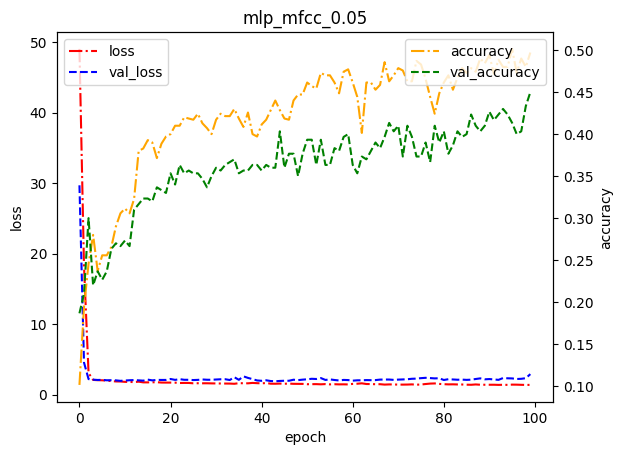

./dataset_city_voice\history\mlp_mfcc_0.0005.csv


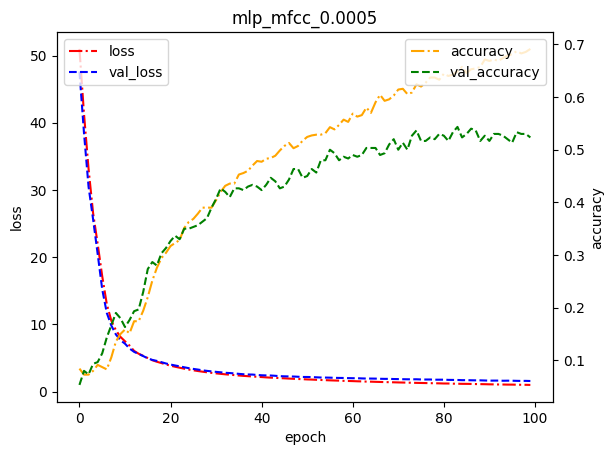

./dataset_city_voice\history\mlp_mfcc_0.0001.csv


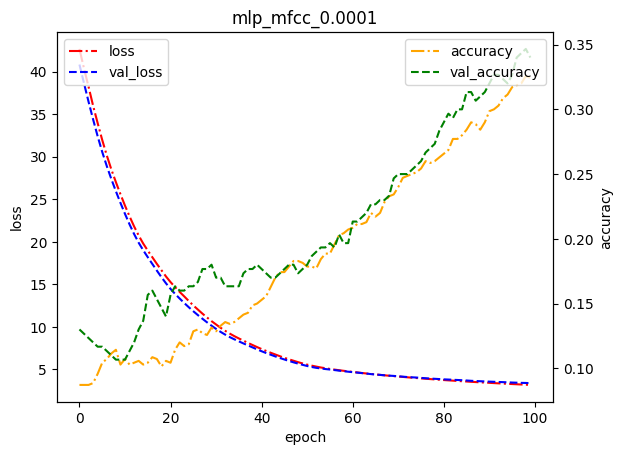

x.shape -> (1000, 12) y.shape -> (1000, 10)
./dataset_city_voice\history\mlp_chroma_0.05.csv


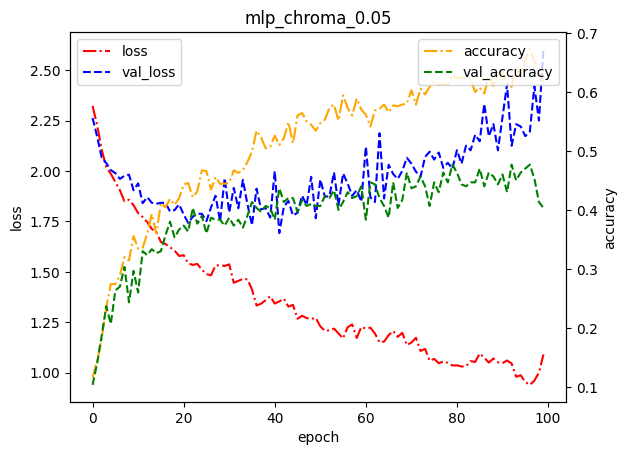

./dataset_city_voice\history\mlp_chroma_0.0005.csv


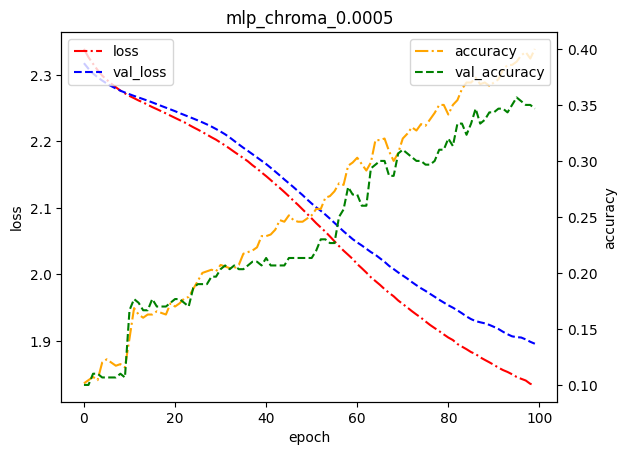

./dataset_city_voice\history\mlp_chroma_0.0001.csv


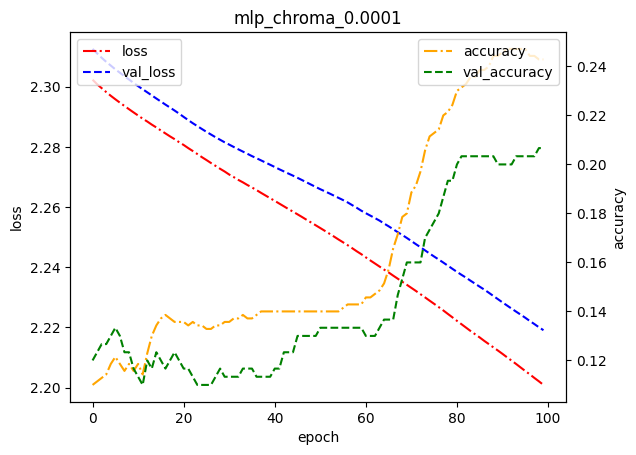

x.shape -> (1000, 40) y.shape -> (1000, 10)
./dataset_city_voice\history\mlp_features_0.05.csv


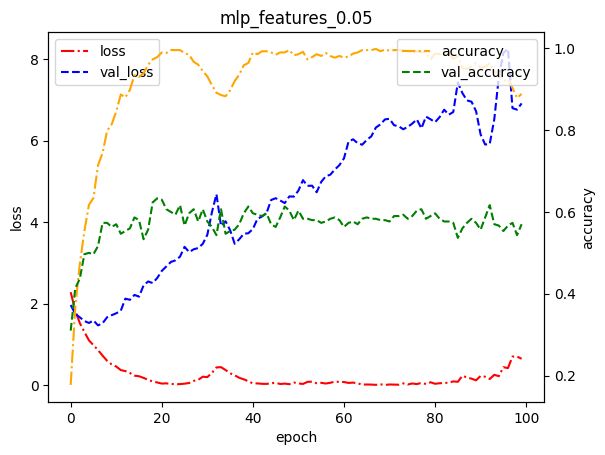

./dataset_city_voice\history\mlp_features_0.0005.csv


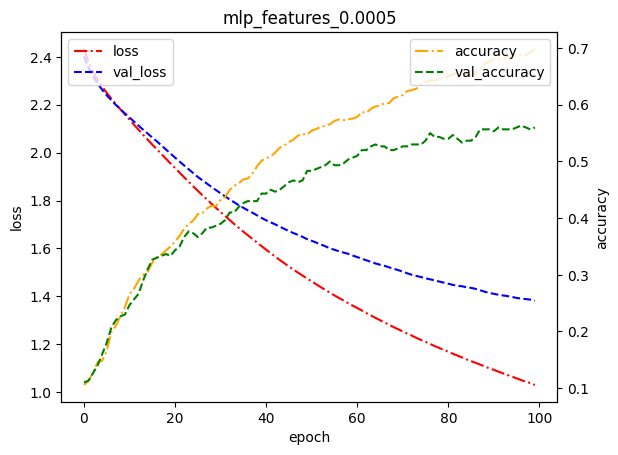

./dataset_city_voice\history\mlp_features_0.0001.csv


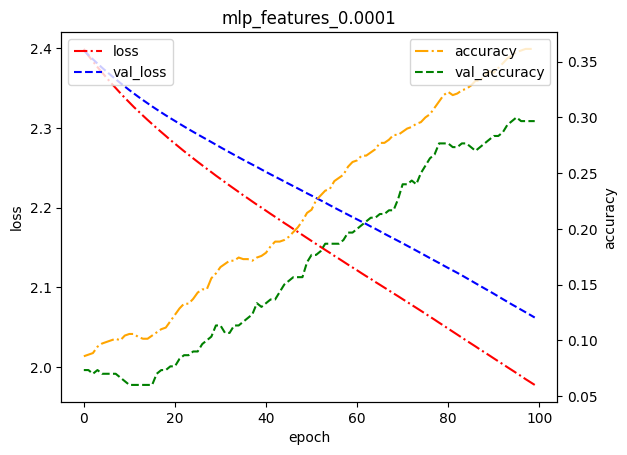

耗时:180.6875


In [34]:
start = time.process_time()
train(src_dir, feature='mfcc', model='mlp')
train(src_dir, feature='chroma', model='mlp')
train(src_dir, feature='features', model='mlp')
print(f'耗时:{time.process_time() - start}')

### 多神经网络对比
- 对比深度神经网络在 deep_neural_networks.ipynb 中